# Projet ML

## 1 - Réalisation d’un algorithme de Q learning

## On importe les librairies nécessaires

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from math import log
from random import randint
from tqdm import tqdm
from tkinter import *

## On crée les fonctions permettant le Q-Learning

In [2]:
def instanciate_Q(env: list):
    """
    Instancier Q
    va initialiser le DataFrame Q en fonction de l'environnement de jeux passé en paramètres

    :param env: environnement de jeux case par case, sous form de matrice transformé en liste
    :type env: liste
    :return Q: la politique du jeux selon la case et l'action (1 case = 1 ligne | 1 action = 1 colonne)
    :rtype Q: DataFrame
    """

    # on définit l'espace de l'environnement de jeux
    state_space = [x for x in range(len(env[0])*len(env))]
    # on lui ajoute une clé de correspondance
    state_key = [1 for x in range(len(env[0])*len(env))]
    # on crée un premier DataFrame correspondant à chaque case du jeu (son état)
    state_space_pd = pd.DataFrame({'key': state_key,'state':state_space})

    # on définit les actions possibles dans le jeux
    action_space = [x for x in range(4)]
    # on lui ajoute une clé de correspondance
    action_key = [1 for x in range(4)]
    # on crée un deuxième DataFrame correspondant à chaque action du jeu
    action_space_pd = pd.DataFrame({'key':action_key, 'action':action_space})

    # on merge les 2 DataFrame en faisant un produit cartésien entre les états et les actions
    Q = pd.merge(state_space_pd, action_space_pd, on='key')
    # on initialise toutes les valeurs à 0
    Q["q_value"] = 0

    # on retourne la politique par défaut
    return Q

def epsilon_greedy(Q: pd.DataFrame, epsilon: float, state: int, first_win: bool):
    """
    Epsilon Greedy
    va renforcer l'exploration
    en choisissant une action choisie ou au hasard entre 0 et 4 selon :
        0 : déplacement vers le haut 
        1 : déplacement vers la droite 
        2 : déplacement vers le bas 
        3 : déplacement vers la gauche 

    :param Q: la politique actuelle du jeux
    :type Q: DataFrame
    :param epsilon: probabilité d'apprentissage
    :type epsilon: float
    :param state: état actuel
    :type state: int
    :param first_win: spécifier si l'on veut arreter à la première victoire ou si l'on veut permettre de recommencer pour trouver un plus court chemin
    :param first_win: bool
    :return chosen_action: action choisie
    :rtype chosen_action: int
    """

    # si le but est de gagner
    if first_win:
        random_action = 1
    else:
        # on choisit une action pour trouver le plus court chemin selon :
            # Au hasard avec une probabilité "epsilon"
            # La meilleure avec une probabilité "1-epsilon"
        random_action = np.random.choice((0, 1), p=[epsilon, (1 - epsilon)])
        
    # soit simplement avec une fonction random
    if random_action == 0:
        chosen_action = randint(0,3)
    
    # soit en prenant la meilleure action qui fut faite dans le passé
    else:
        # on prépare le filtre de sélection en fonction de l’état actuel
        select_current_state = (Q["state"] == state)

        # on récupère la valeur max
        value_max = np.max(Q[select_current_state]["q_value"])

        # on prépare le filtre de sélection en fonction de la valeur max
        select_max_reward = (Q["q_value"] == value_max)

        # si plusieurs action donnent la valeur max, alors on en choisit une au hasard
        chosen_action = np.random.choice(Q[select_current_state & select_max_reward]["action"])

    # on retourne l'action choisie
    return chosen_action

def Q_learning(Q: pd.DataFrame, alpha: float, state: int, reward: int, chosen_action: int, next_state: int, lambda_: float):
    """
    Q learning
    va pour modifier la politique

    :param Q: la politique actuelle du jeux
    :type Q: DataFrame
    :param alpha: coefficient d'apprentissage
    :type alpha: float
    :param state: état actuel
    :type state: int
    :param reward: récompense
    :type reward: int
    :param chosen_action: action choisie
    :type chosen_action: int
    :param next_state: prochain état
    :type next_state: int
    :param lambda_: récompense future
    :type lambda_: float
    :return Q: la nouvelle politique du jeux selon alpha, lambda, le statut et l'action
    :rtype Q: DataFrame
    """

    # on prépare les filtres de sélection en fonction de l’état actuel, l’état suivant et l’action choisie
    select_current_state = (Q["state"] == state)
    select_next_state = (Q["state"] == next_state)
    select_chosen_action = (Q["action"] == chosen_action)

    # on va chercher la valeur de la politique de l'etat actuel et de l'action choisie
    current_Q_value = Q.loc[select_current_state & select_chosen_action, "q_value"]

    # on calcul l'estimation de la politique 
    estimate_Q_value = reward + lambda_ * np.max(Q.loc[select_next_state, "q_value"])
    
    # on met à jour la politique actuelle par l'estimation
    new_Q_value = current_Q_value + alpha * (estimate_Q_value - current_Q_value)
    Q.loc[select_current_state & select_chosen_action, "q_value"] = new_Q_value

    # on retourne la nouvelle politique
    return Q

def play(env: list, alpha: float, lambda_: float, nb_game: int, first_win: bool):
    """
    Play
    va jouer un nombre de partie pour apprendre comment gagner au mieux

    :param env: environnement de jeux case par case, sous form de matrice transformé en liste
    :type env: liste
    :param alpha: coefficient d'apprentissage
    :type alpha: float
    :param lambda_: récompense future
    :type lambda_: float
    :param nb_game: nombre de partie à jouer
    :type nb_game: int
    :param first_win: spécifier si l'on veut arreter à la première victoire ou si l'on veut permettre de recommencer pour trouver un plus court chemin
    :param first_win: bool
    :return Q: la politique du jeux selon la case et l'action (1 case = 1 ligne | 1 action = 1 colonne)
    :rtype Q: DataFrame
    :return resultats: l'ensemble des coups effectués par l'apprentissage
    :rtype resultats: DataFrame
    """

    ################
    # Instancation #
    ################

    wall_reward = -4
    action_reward = 1
    dragon_reward = -5
    win_reward = 100
    undo_reward = -1
    
    # on instancie les recompenses du plateau selon l'environnement de jeu
    plateau = [char for char in "".join(env)]
    plateau = [0 if x=="S" else x for x in plateau] # S pour "start"
    plateau = [action_reward if x=="R" else x for x in plateau] # R pour "rien"
    plateau = [dragon_reward if x=="D" else x for x in plateau] # D pour "dragon"
    plateau = [win_reward if x=="E" else x for x in plateau] # E pour "end"

    # on instancie le nombre de colonne et de ligne selon l'environnement de jeu
    nb_colonne = len(env[0])
    nb_ligne = len(env)

    # on instancie la politique de jeu par défaut (0)
    Q = instanciate_Q(env)

    # on instancie le DataFrame de resultats avec chaque étape correspond à 1 ligne
    resultats = pd.DataFrame(columns=['game','step','done','state','action','next_state','reward'])

    ##############
    # Traitement # 
    ##############

    # Boucle d’apprentissage (exploration mode) selon le nombre de partie
    for game in tqdm(range(nb_game)):
        
        # on (re)initialise epsilon
        epsilon = nb_game/(nb_game+game)
        # on (re)initialise le fait d'être mort ou arrivé
        done = False
        # on (re)initialise le numéro de l'étape
        step=0
        # on (re)initialise l'état
        state = 0
        # on initialise l'état précedent
        previous_state = [0]
        
        
        # tant qu'on est pas mort ou arrivé
        while not done:
            
            # Choisir une action avec une politique ecploration - renforcement : Epsilon greedy
            action = epsilon_greedy(Q, epsilon, state, first_win)
            
            # on initialise la première récompense
            reward = action_reward
                    
            # L'envoyer à l'environnement et récupérer la réponse selon la possibilité ou non du mouvement (effet de bord)
            if action == 1 and state%(nb_colonne) != nb_colonne-1:
                next_state = state + 1
            elif action == 3 and state%nb_colonne != 0:
                next_state = state - 1
            elif action == 0 and state >= nb_colonne:
                next_state = state - nb_colonne
            elif action == 2 and state <= nb_ligne * nb_colonne - 1 - nb_colonne:
                next_state = state + nb_colonne
            else:
                next_state = state
                reward = wall_reward

            if next_state in previous_state:
                reward = undo_reward
                if next_state==previous_state[-1]:
                    next_state=state

            # si l'action était bien possible
            if reward == action_reward:
                # on va chercher la récompense du prochain état
                reward = plateau[next_state]
            
            # si on est tombé sur une récompense dragon ou de victoire
            if reward==dragon_reward or reward==win_reward:
                # c'est que la partie est finie
                done = True
            
            # on apprend de cette experience
            Q = Q_learning(Q, alpha, state, reward, action, next_state, lambda_)
            
            # on enregistre les résultats
            resultats = resultats.append({'game': game,
                                        'step' : step,
                                        'done' : done,
                                        'state': state,
                                        'action': action,
                                        'next_state': next_state,
                                        'reward' : reward,}, ignore_index=True)
            
            # on incrémente l'étape
            step +=1
            # on garde en mémoire l'etat
            previous_state.append(state)
            # on affecte le nouvel état à l'ancien
            state = next_state
            
            if reward==win_reward and first_win==True:
                print("Done")
                return Q, resultats
    
    # on retourne la politique et les resultats
    return Q, resultats

## On crée les fonctions permettant d'afficher les resultats sous forme de :
* ### Courbe de réussite 
* ### Historique d'étape sur un plateau de jeux

In [3]:
def show_resultats(resultats: pd.DataFrame):
    """
    Show resultats
    va afficher la réussite moyenne selon un groupe de partie de taille passée en paramètre

    :param resultats: l'ensemble des des coups effectué par l'apprentissage
    :type resultats: DataFrame
    :return resultats: l'ensemble des moyenne de récompense par groupe de partie
    :rtype resultats: list
    """
    
    # on regroupe les resultats par partie pour compter le nombre d'étape de chacun avant la fin
    game_results_step = resultats.groupby("game").count().step
    # on regroupe les resultats par partie avoir la récompense finale
    game_results_reward = resultats.groupby("game").sum().reward

    # on affiche les 2 series
    fig, ax = plt.subplots()
    ax.plot(game_results_step, '-b', label='Nb Partie')
    ax.plot(game_results_reward, '--r', label='Récompense')
    leg = ax.legend(loc='upper left', frameon=True);
    plt.show()
    
    # on identifie une taille des groupe de resultats selon le logarithme néperien
    group_size = int(log(len(game_results_reward)))
    # on compte le nombre de groupe selon le nombre de partie et la taille des groupes
    nb_group = len(game_results_reward)//group_size + 1
    # on initialise les resultats
    resultats_by_group = list()

    # pour chaque groupe de partie, on ajoute la moyenne de ces récompenses finales aux resultats 
    for i in range(nb_group):
        resultats_by_group.append(np.mean(game_results_reward[group_size*i:group_size*(i+1)]))

    # on affiche la série 
    plt.plot(resultats_by_group)
    plt.title(f"Moyenne des resultats par groupe de {group_size}")
    plt.show()
    
    # on retourne les resultats
    return resultats_by_group

def show_game(env: list, resultats: pd.DataFrame):
    """
    Show game
    va afficher tous les chemins emprunter pour chaque partie

    :param env: environnement de jeux case par case, sous form de matrice transformé en liste
    :type env: liste
    :param resultats: l'ensemble des des coups effectué par l'apprentissage
    :type resultats: DataFrame
    """

    # on instancie le visuel du plateau selon l'environnement de jeu
    plateau = [char for char in "".join(env)]

    # on instancie le nombre de colonne et de ligne selon l'environnement de jeu
    nb_colonne = len(env[0])
    nb_ligne = len(env)

    # on crée une fenetre vierge de 1000 pixel de largeur par 500 de hauteur
    ma_fenetre = Tk()
    ma_fenetre.geometry(f"1400x700+0+0")
    ma_fenetre.title("Plateau")

    # on instancie la taille des cases à 70 pixel de largeur pour 35 de hauteur
    case_largeur=70
    case_hauteur=35
    
    # on instancie la zone de dessin selon la taille et le nombre de cases
    dessin_largeur=int(case_largeur*nb_colonne)
    dessin_hauteur=int(case_hauteur*nb_ligne)

    # zone de dessin qu'on incorpore au centre de notre fenetre
    zone_dessin = Canvas(ma_fenetre, width=dessin_largeur, height=dessin_hauteur, bg='white')
    zone_dessin.place(relx=0.5, rely=0.5, anchor=CENTER)

    # on crée un dictionnaire pour attribuer un nombre à chacune de nos cases
    dict_rectangle = {}

    # k correspond au numero de la case
    k=0
    # on crée chaque case avec ses paramètres de jeu et son numéro k
    for y in range(0, dessin_hauteur, case_hauteur):
        for x in range(0, dessin_largeur, case_largeur):
            dict_rectangle[k] = zone_dessin.create_rectangle(x,y,x+case_largeur,y+case_hauteur,fill='grey',outline="black")
            zone_dessin.create_text((x+(case_largeur/2), y+(case_hauteur/2)), text=plateau[k])
            k += 1

    # on crée des variables globales pour suivre la mise à jour des chemins sans passer par une boucle for ou while
    global i, num_game, nb_case, success
    # on incremente le numero du coup, le numero de la partie, le nombre de succès et le nombre de case
    i = 0
    num_game = 0
    success = 0
    nb_case = nb_ligne*nb_colonne

    # on crée une fonction pour empecher de relancer la fonction run avant qu'elle ne soit terminée
    def rien():
        return
    
    # o crée une fonction pour afficher en jaune les cases sur lesquelles on est passées
    def run():
        # on reprend l'uusage de nos variables globales
        global i, num_game, nb_case, success
        # si on est aau dernier coup
        if i == len(resultats):
            return
        
        # si on est après le premier coup
        if i>0:
            # si le coup d'avant était une fin de partie alors on affiche toutes les cases en grises
            if resultats.done[i-1]==True:
                for k in range(1, nb_case):
                    zone_dessin.itemconfigure(dict_rectangle[k], fill='grey')
        
        # on affiche la case jaune
        zone_dessin.itemconfigure(dict_rectangle[resultats.state[i]], fill='yellow')
        # on affiche le numéro de partie sur la case victorieuse
        zone_dessin.itemconfigure(nb_case*2, text=f"Partie : {num_game}")       
        # si c'est une fin de partie alors on affiche la case suivante en jaune
        if resultats.done[i]==True:
            zone_dessin.itemconfigure(dict_rectangle[resultats.next_state[i]], fill='yellow') 
            # si c'est une fin de partie victorieuse alors on incremente la variable succès
            if resultats.reward[i]==100:
                success += 1
                # on affiche sur le bouton Run le nombre de succès
                btn.configure(text=f"Succès : {success}", command=rien)         

        # on re instancie le numéro de partie
        num_game = resultats.loc[i,"game"]
        # on incremente le nmero du coup
        i += 1
        # on relance la fonction run
        zone_dessin.after(1, run) 

    # on crée un bouton en bas pour lancer l'appercu des parties
    btn = Button(ma_fenetre, text="Run", width=dessin_largeur, command=run)
    btn.pack(side=BOTTOM, padx=5, pady=5)

    # on lance l'affichage de la fenetre
    ma_fenetre.mainloop()

## On test notre algorithme sur l'environnement du projet en 3x3

In [80]:
# on spécifie les paramètres
alpha = 0.19
lambda_ = 0.96
nb_game = 10000

# on spécifie l'environnement
env = ["SRRR", 
       "DRDR", 
       "RRRD", 
       "RDRE"]

# on lance le traitement
Q, resultats = play(env, alpha, lambda_, nb_game, first_win=True)


  0%|                                                                                | 3/10000 [00:00<17:46,  9.38it/s]

Done


## On affiche les resultats sous la forme d'une :
* ### Courbe de récompense par partie
* ### Courbe regroupant les récompenses par un nombre de groupe adapté au nombre de partie jouée

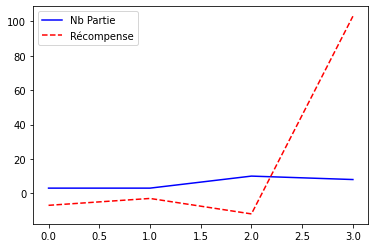

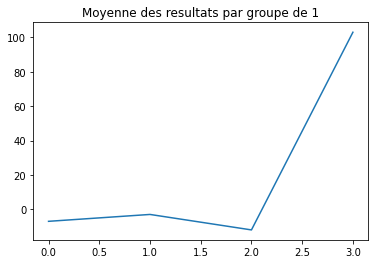

In [81]:
resultats_by_group = show_resultats(resultats)

## On affiche l'historique des parties sur un plateau correspondant à l'environnement de jeu

In [116]:
show_game(env, resultats)

## On test notre algorithme sur un environnement plus ambicieux en 5x4

  0%|▏                                                                              | 16/10000 [00:02<26:12,  6.35it/s]


Done


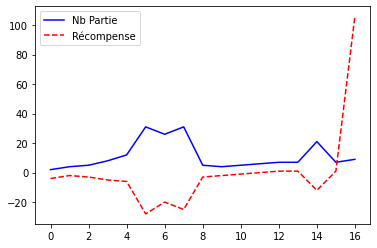

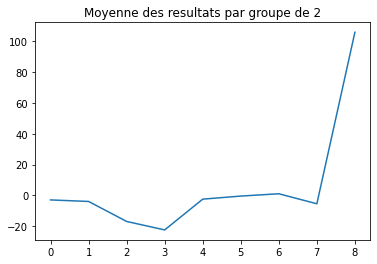

In [83]:
# Deuxième test : 5 par 4
alpha = 0.19
lambda_ = 0.96
nb_game = 10000

env = ["SRDRRD", 
       "DRRRDR", 
       "DRDRRR", 
       "RRDRDE"]

# on lance le traitement
Q, resultats = play(env, alpha, lambda_, nb_game, first_win=True)
resultats_by_group = show_resultats(resultats)
show_game(env, resultats)

## On test notre algorithme sur un environnement encore plus ambicieux à taille variable

  0%|                                                                                | 2/10000 [00:00<13:43, 12.14it/s]

SRRRRRRDRD
RRRRRRRDRR
RRDRDRDRRR
RRRDRRRRRR
DDRRRRDRRR
RRRRDDRRRR
RRRRRRRRRR
RRRRRRRDRR
RRDRRRRRDR
RRRRRRRRRE


  0%|▏                                                                            | 22/10000 [00:08<1:03:27,  2.62it/s]

Done


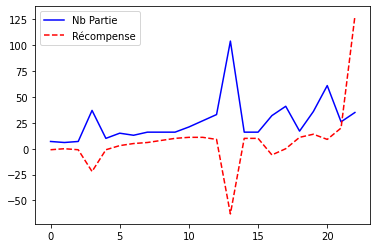

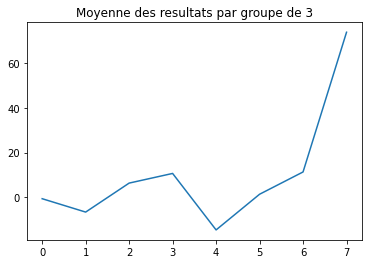

In [13]:
#%% Troisième test : X par X aléatoire
alpha = 0.19
lambda_ = 0.96
nb_game = 10000
nb_case = 10

env = "".join(["S"]+[np.random.choice(("R","D"), p=[0.8, 0.2]) for i in range(nb_case*nb_case-2)]+["E"])
env = [env[i:i+nb_case] for i in range(0, len(env), nb_case)]
for n in range(nb_case):
    print(env[n])
# on lance le traitement si l'environnement convient
Q, resultats = play(env, alpha, lambda_, nb_game, first_win=True)
resultats_by_group = show_resultats(resultats)
show_game(env, resultats)

## J'ai fais plusieurs test que l'on peut recharger pour éviter le temps de traitement

## On crée les fonctions de sauvegarde et de recharge

In [5]:
def save_resultats(resultats: pd.DataFrame, Q: pd.DataFrame, env: list, suffix: str):
    """
    Save Resultats
    va sauvegarder les resultats du présent test

    :param resultats: l'ensemble des coups effectués par l'apprentissage
    :type resultats: DataFrame
    :param Q: la politique du jeux selon la case et l'action (1 case = 1 ligne | 1 action = 1 colonne)
    :type Q: DataFrame
    :param env: l'environnement de jeu
    :type env: list
    :param suffix: le suffix qu'on donne au nom des fichiers de sauvegarde
    :type suffix: str
    """
    
    # on sauvegarde les resultats au format csv
    resultats.to_csv(f"res/resultats{len(env)}{suffix}.csv", index=False)
    
    # on sauvegarde la politique au format csv
    Q.to_csv(f"res/Q{len(env)}{suffix}.csv", index=False)
    
    # on sauvegarde l'environnement au format txt
    file = open(f"res/env{len(env)}{suffix}.txt","w")
    # on lui donne un format bien précis pour faciliter la lecture de son utilisateur (format carré)
    file.write("['")
    for i in range(len(env)):
        file.write(env[i])
        if i == len(env)-1:
            file.write("']")
        else:
            file.write("',\n '")
    file.close()
    
    # on affiche la réussite de la sauvegarde
    print(f"Les résultats de l'environnement de taille {len(env)} ont bien été sauvegardés")
    
def load_resultats(taille: int, suffix: str):
    """
    Load Resultats
    va recharger les resultats de test sauvegardés precedemment

    :param taille: la taille de l'environnement que vous voulez recharger
    :type taille: int
    :param suffix: le suffix qu'on donne au nom des fichiers de sauvegarde
    :type suffix: str
    :return resultats: l'ensemble des coups effectués par l'apprentissage
    :rtype resultats: DataFrame
    :return Q: la politique du jeux selon la case et l'action (1 case = 1 ligne | 1 action = 1 colonne)
    :rtype Q: DataFrame
    :return env: l'environnement de jeu
    :rtype env: list
    """
    
    # on va lire le csv des resultats
    resultats = pd.read_csv(f"res/resultats{taille}{suffix}.csv")
    
    # on va lire le csv de la politique de jeu
    Q = pd.read_csv(f"res/Q{taille}{suffix}.csv")
    
    # on va lire le fichier txt dans lequel est conservé l'environnement de jeu
    env = open(f"res/env{taille}{suffix}.txt").read()[2:-2].replace("',\n '","")
    # on le divise par ligne pour retrouver le format carré de lenvironnement
    env = [env[i:i+int(taille)] for i in range(0,len(env), int(taille))]

    # on retourne l'historique d'apprentissage, la politique et l'environnement de jeu
    return resultats, Q, env

## On spécifie juste la taille de l'environnement que l'on veut recharger pour afficher ses resultats

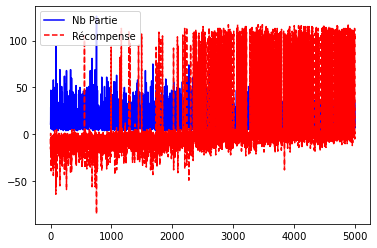

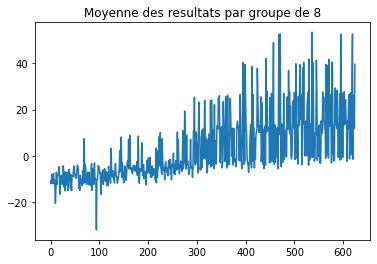

In [11]:
# A vous de préciser la taille de l'environnement que vous voulez recharger
taille = 9
# On spécifie le resultats que l'on veut entre "_first_win" et "_all"
suffix = "_all"

# on récupère l'historique d'apprentissage, la politique et l'environnement de jeu
resultats, Q, env = load_resultats(taille, suffix)

# on affiche la meilleure action de jeu selon l'état et la politique de jeu entrainée
Q.iloc[Q.groupby("state").q_value.idxmax(),:]

# on affiche les resultats
resultats_by_group = show_resultats(resultats)

# on affiche l'historique d'apprentissage sur le plateau de jeu qui convient à l'environnement
show_game(env, resultats)

## PS : Comment j'ai sauvegardé mes tests rapidement

In [ ]:
# for nb_case in range(2,20):
    alpha = 0.19
    lambda_ = 0.96
    nb_game = 5000

    env = "".join(["S"]+[np.random.choice(("R","D"), p=[0.8, 0.2]) for i in range(nb_case*nb_case-2)]+["E"])
    env = [env[i:i+nb_case] for i in range(0, len(env), nb_case)]
    for n in range(nb_case):
        print(env[n])
    # on lance le traitement si l'environnement convient
    Q, resultats = play(env, alpha, lambda_, nb_game, first_win=True)
    # on sauvegarde les resultats
    save_resultats(resultats, Q, env, "_first_win")
    
    show_resultats(resultats)

In [ ]:
# for nb_case in range(2,10):
    alpha = 0.19
    lambda_ = 0.96
    nb_game = 5000

    env = "".join(["S"]+[np.random.choice(("R","D"), p=[0.8, 0.2]) for i in range(nb_case*nb_case-2)]+["E"])
    env = [env[i:i+nb_case] for i in range(0, len(env), nb_case)]
    for n in range(nb_case):
        print(env[n])
    # on lance le traitement si l'environnement convient
    Q, resultats = play(env, alpha, lambda_, nb_game, first_win=False)
    # on sauvegarde les resultats
    save_resultats(resultats, Q, env, "_all")
    
    show_resultats(resultats)